# Coursera & IBM: Unsupervised Machine Learning Final Project: Mushroom Clustering
Q: To use the tools and techniques you learned throughout this course to develop a few **clustering models** or **dimension reduction transformations** on a data set that you feel passionate about. Then, you will select the algorithm regression that best suits your needs, and **communicate insights** you found from your clustering or dimension reduction exercise.


In this work, I choose the **mushroom dataset** from Kaggle contributed to the UCI Machine Learning repository and aim at performing unsupervised ML to **cluster mushrooms** and **compared it with its class** whether it is poisonous.

Although this dataset was first introduced to the UCI Machine Learning repository almost three decades ago, mushroom hunting (also known as "shrooming") is gaining new popularity. With this dataset, you can identify which features make certain mushrooms deadly and which ones are delicious. The dataset contains descriptions of 23 different species of gilled mushrooms in the Agaricus and Lepiota Family, each labeled as definitely edible, definitely poisonous, or of unknown edibility and not recommended. However, as the Audubon Society Field Guide to North American Mushrooms states, there is no one simple rule to determine the edibility of a mushroom, making the task of building a model with high accuracy an interesting challenge.

My work is organized as the following:
* Objectives and packages
* Data Inspection
* Data Encodings
* Dimensionality Reduction by PCA
* Dimensionality Reduction by MDS
* Clustering by Kmeans
* Clustering by DBSCAN
* Summary and Discussion

<img src="mushroom.jpg" alt="Cannot load imag" />

# Objective and Packages
## Objective
In this course work, I will cluster mushroom data with unsupervised ML based on raw encoded data and dimensional reduced data. I will draw some insights from data and compare each technique.
## Packages

In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans


In [2]:
def hist_plots(X_reduced:np.ndarray,n:int,titles:list = []):
    # create figure with 5 subplots
    fig, axs = plt.subplots(1, n, figsize=(15, 3))

    # create histograms for each array
    for i in range(n):
        arr = X_reduced[:,i]
        axs[i].hist(arr, bins=10)
        # add labels and title to each subplot
        axs[i].set_xlabel('Value')
        axs[i].set_ylabel('Frequency')
        axs[i].set_title(titles[i])
    plt.subplots_adjust(wspace=0.5)
    plt.show()

In [3]:
def plot_scatter_ax(ax,i, j,X ,labels, x_label = '', y_label = '', title = ''):
    ax.scatter(X[:, i], X[:, j], c=labels, cmap='viridis')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    

In [4]:

def show_barcharts(df:pd.DataFrame, feature_col:str = 'features', bin_col:str = 'type', freq_col:str = 'count',
                   color_col:str = 'class', mapping:dict = dict()):
    
    to_map = len(mapping) > 0
        
    # Determine the unique bins in the data
    features = np.unique(df[feature_col])

    # Determine the width of each bar
    bar_width = 1.0 / (len(features) + 1)

    # Create a figure with a subplot for each bin
    fig, axs = plt.subplots(1, len(features), figsize=(15, 5))

    # Iterate over the bins and create a bar chart for each bin
    for i, feature in enumerate(features):
        # Filter the dataframe to only include rows with the current bin
        data = df[df[feature_col] == feature].sort_values([bin_col,'class'])
        if to_map:
            data[bin_col] = data[bin_col].map(mapping[feature])
        
        bottom = np.zeros(len(np.unique(data[bin_col])))
        # define the proper ordering
        df_counts = data.groupby(bin_col).sum()
        order = df_counts.sort_values(freq_col,ascending = False).reset_index()[bin_col]

        # Create a bar chart for the current bin
        for class_ in np.unique(df[color_col]):
            data_class = data[data[color_col] == class_][[bin_col,freq_col]]\
            .merge(data[[bin_col]].drop_duplicates(), on = bin_col, how ='outer').fillna(0)\
            .set_index(bin_col).loc[order]\
            .reset_index()
            
            p = axs[i].bar(data_class[bin_col], data_class[freq_col], width=bar_width, label = class_,bottom = bottom)
            bottom += data_class[freq_col]

        axs[i].set_title(feature)
        axs[i].grid()
        axs[i].set_axisbelow(True)
        axs[i].set_xticks(data[bin_col])
        axs[i].set_xticklabels(data[bin_col])
        axs[i].set_xticklabels(data[bin_col], rotation=90)
        axs[i].legend()
    # Adjust the layout and show the plot
    fig.tight_layout()
    plt.show()


In [5]:
def matrix_cplots(xx,yy,zz_ls):
    fig, axs = plt.subplots(1, len(zz_ls), figsize=(4*len(zz_ls), 3))
    for cnt in range(len(zz_ls)):
        ax = axs[cnt]
        zz = zz_ls[cnt]
        ax.pcolor(xx,yy,np.log(zz))
        for i,eps in enumerate(xx[0]):
            for j,min_samples in enumerate(yy[:,0]):
                x0 = xx[i,j]
                y0 = yy[i,j]
                ax.annotate(str(round(zz[i,j],2)), 
                             xy=(x0,y0), ha='center', 
                             va='center',color='white')
    plt.show()

# Data Inspection
The mushroom data of class (e: edible and p: poisonous) is encoded with the following abbreviation
* cap-shape: bell=b,conical=c,convex=x,flat=f, knobbed=k,sunken=s
* cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s
* cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y
* bruises: bruises=t,no=f
* odor: almond=a,anise=l,creosote=c,fishy=y,foul=f,musty=m,none=n,pungent=p,spicy=s
* gill-attachment: attached=a,descending=d,free=f,notched=n
* gill-spacing: close=c,crowded=w,distant=d
* gill-size: broad=b,narrow=n
* gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g, green=r,orange=o,pink=p,purple=u,red=e,white=w,yellow=y
* stalk-shape: enlarging=e,tapering=t
* stalk-root: bulbous=b,club=c,cup=u,equal=e,rhizomorphs=z,rooted=r,missing=?
* stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s
* stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s
* stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
* stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
* veil-type: partial=p,universal=u
* veil-color: brown=n,orange=o,white=w,yellow=y
* ring-number: none=n,one=o,two=t
* ring-type: cobwebby=c,evanescent=e,flaring=f,large=l,none=n,pendant=p,sheathing=s,zone=z
* spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r,orange=o,purple=u,white=w,yellow=y
* population: abundant=a,clustered=c,numerous=n,scattered=s,several=v,solitary=y
* habitat: grasses=g,leaves=l,meadows=m,paths=p,urban=u,waste=w,woods=d

In [6]:
abbr_mapping = {
    'cap-shape': {'b': 'bell', 'c': 'conical', 'x': 'convex', 'f': 'flat', 'k': 'knobbed', 's': 'sunken'},
    'cap-surface': {'f': 'fibrous', 'g': 'grooves', 'y': 'scaly', 's': 'smooth'},
    'cap-color': {'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'r': 'green', 'p': 'pink', 'u': 'purple', 'e': 'red', 'w': 'white', 'y': 'yellow'},
    'bruises': {'t': 'bruises', 'f': 'no'},
    'odor': {'a': 'almond', 'l': 'anise', 'c': 'creosote', 'y': 'fishy', 'f': 'foul', 'm': 'musty', 'n': 'none', 'p': 'pungent', 's': 'spicy'},
    'gill-attachment': {'a': 'attached', 'd': 'descending', 'f': 'free', 'n': 'notched'},
    'gill-spacing': {'c': 'close', 'w': 'crowded', 'd': 'distant'},
    'gill-size': {'b': 'broad', 'n': 'narrow'},
    'gill-color': {'k': 'black', 'n': 'brown', 'b': 'buff', 'h': 'chocolate', 'g': 'gray', 'r': 'green', 'o': 'orange', 'p': 'pink', 'u': 'purple', 'e': 'red', 'w': 'white', 'y': 'yellow'},
    'stalk-shape': {'e': 'enlarging', 't': 'tapering'},
    'stalk-root': {'b': 'bulbous', 'c': 'club', 'u': 'cup', 'e': 'equal', 'z': 'rhizomorphs', 'r': 'rooted', '?': 'missing', 'nan':'missing'},
    'stalk-surface-above-ring': {'f': 'fibrous', 'y': 'scaly', 'k': 'silky', 's': 'smooth'},
    'stalk-surface-below-ring': {'f': 'fibrous', 'y': 'scaly', 'k': 'silky', 's': 'smooth'},
    'stalk-color-above-ring': {'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'o': 'orange', 'p': 'pink', 'e': 'red', 'w': 'white', 'y': 'yellow'},
    'stalk-color-below-ring': {'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'o': 'orange', 'p': 'pink', 'e': 'red', 'w': 'white', 'y': 'yellow'},
    'veil-type': {'p': 'partial', 'u': 'universal'},
    'veil-color': {'n': 'brown', 'o': 'orange', 'w': 'white', 'y': 'yellow'},
    'ring-number': {'n': 'none', 'o': 'one', 't': 'two'},
    'ring-type': {'c': 'cobwebby', 'e': 'evanescent', 'f': 'flaring', 'l': 'large', 'n': 'none', 'p': 'pendant', 's': 'sheathing', 'z': 'zone'},
    'spore-print-color': {'k': 'black', 'n': 'brown', 'b': 'buff', 'h': 'chocolate', 'r': 'green', 'o': 'orange', 'u': 'purple', 'w': 'white', 'y': 'yellow'},
    'population': {'a': 'abundant', 'c': 'clustered', 'n': 'numerous', 's': 'scattered', 'v': 'several', 'y': 'solitary'},
    'habitat': {'g': 'grasses', 'l': 'leaves', 'm': 'meadows', 'p': 'paths', 'u': 'urban', 'w': 'waste', 'd': 'woods'}
}

In [7]:
# load data
# since we know '?' means nan from the document, we replace it to None for now 
df_raw = pd.read_csv('mushrooms.csv').replace('?', None)
df_raw.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [8]:
# check for duplicates
print(df_raw.shape)
print(df_raw.drop_duplicates().shape)

(8124, 23)
(8124, 23)


In [9]:
# to show the info for mushroom data
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                5644 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

In [10]:
# replace none with 'nan'
df_raw = df_raw.fillna('nan')

In [11]:
# define a function to check imbalance of each features
def feature_info_(df: pd.DataFrame)-> pd.DataFrame:
    df = df.sort_values('count').reset_index(drop=True)
    max_type = df.iloc[-1]['type']
    max_cnt = df.iloc[-1]['count']
    min_type = df.iloc[0]['type']
    min_cnt = df.iloc[0]['count']
    ut = len(df['type'].unique())
    std = np.std(df['count'])
    imb = max_cnt - min_cnt
    return pd.DataFrame({'max_type': [max_type], 
                         'max_count': [max_cnt], 
                         'min_type':[min_type], 
                         'min_count':[min_cnt],
                         'unique_types': [ut],
                         'cnt_variation': [std],
                         'imbalance': [imb]}
                       ).set_index('max_type')

# get data frequencies
df_counts =  pd.melt(df_raw.reset_index(), id_vars = 'index', var_name = 'features', value_name = 'type')\
.groupby(['features','type']).count()\
.reset_index().rename(columns = {'index': 'count'})

# get by class frequencies
df_by_class_cnt =  pd.melt(df_raw.reset_index(), id_vars = ['index','class'], var_name = 'features', value_name = 'type')\
.groupby(['features','type','class']).count()\
.reset_index().rename(columns = {'index': 'count'})

# get summary of frequencies
df_summary = df_counts\
.groupby('features').apply(feature_info_).reset_index()\
.sort_values('max_count')
df_summary

,features,max_type,max_count,min_type,min_count,unique_types,cnt_variation,imbalance
6,gill-color,b,1728,r,24,12,561.719681,1704
1,cap-color,n,2284,r,16,10,808.363186,2268
14,spore-print-color,w,2388,b,48,9,967.500330,2340
9,habitat,d,3148,w,192,7,1024.962558,2956
3,cap-surface,y,3244,g,4,4,1218.528211,3240
10,odor,n,3528,m,36,9,1098.805816,3492
2,cap-shape,x,3656,c,4,6,1482.816689,3652
17,stalk-root,b,3776,r,192,5,1327.335737,3584
13,ring-type,p,3968,n,36,5,1544.962187,3932
11,population,v,4040,c,340,6,1305.961204,3700


In [12]:
print(f'total datapoints:                        {df_raw.shape[0]}')
print(f'total features:                          {df_raw.shape[1]-1}')
print(f'median types in a feature:               {np.median(df_summary["unique_types"])}')
print(f'median max_freq - min_freq in a feature: {np.median(df_summary["imbalance"])} ')
print(f'median std of freq in a feature:         {np.median(df_summary["cnt_variation"])} ')

total datapoints:                        8124
total features:                          22
median types in a feature:               4.0
median max_freq - min_freq in a feature: 3584.0 
median std of freq in a feature:         1327.3357374831733 


### most-level features

In [13]:
df_summary.sort_values('unique_types').tail(5)

,features,max_type,max_count,min_type,min_count,unique_types,cnt_variation,imbalance
10,odor,n,3528,m,36,9,1098.805816,3492
14,spore-print-color,w,2388,b,48,9,967.500330,2340
15,stalk-color-above-ring,w,4464,y,8,9,1368.898990,4456
1,cap-color,n,2284,r,16,10,808.363186,2268
6,gill-color,b,1728,r,24,12,561.719681,1704


The features with the most levels are cap-color, gill-color, stalk-color-above-ring, spore-print-color and oder, with 9 to 12 levels

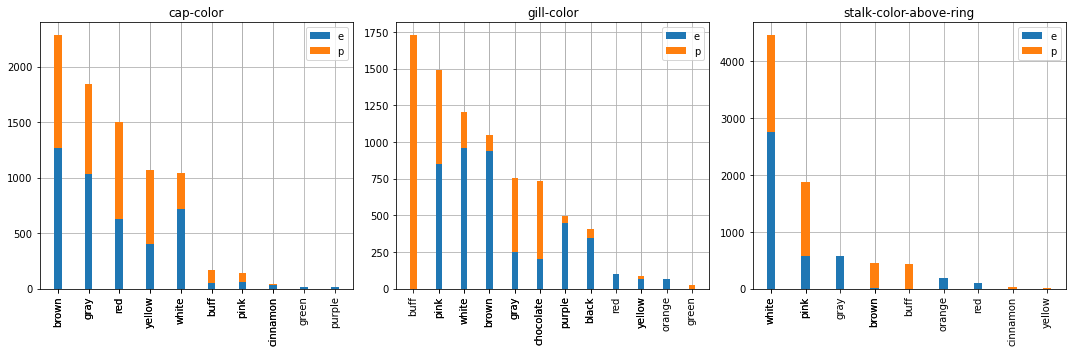

In [14]:
show_barcharts(
df_by_class_cnt[df_by_class_cnt['features'].isin(df_summary.sort_values('unique_types').tail(3).features)],
    mapping = abbr_mapping
)

### Most imbalanced features

In [15]:
df_summary.sort_values('cnt_variation').tail(5)

,features,max_type,max_count,min_type,min_count,unique_types,cnt_variation,imbalance
19,stalk-surface-above-ring,s,5176,y,24,4,2013.876610,5152
8,gill-spacing,c,6812,w,1312,2,2750.000000,5500
12,ring-number,o,7488,n,36,3,3387.804008,7452
21,veil-color,w,7924,y,8,4,3402.514805,7916
5,gill-attachment,f,7914,a,210,2,3852.000000,7704


In [16]:
df_summary.sort_values('imbalance').tail(5)

,features,max_type,max_count,min_type,min_count,unique_types,cnt_variation,imbalance
19,stalk-surface-above-ring,s,5176,y,24,4,2013.876610,5152
8,gill-spacing,c,6812,w,1312,2,2750.000000,5500
12,ring-number,o,7488,n,36,3,3387.804008,7452
5,gill-attachment,f,7914,a,210,2,3852.000000,7704
21,veil-color,w,7924,y,8,4,3402.514805,7916


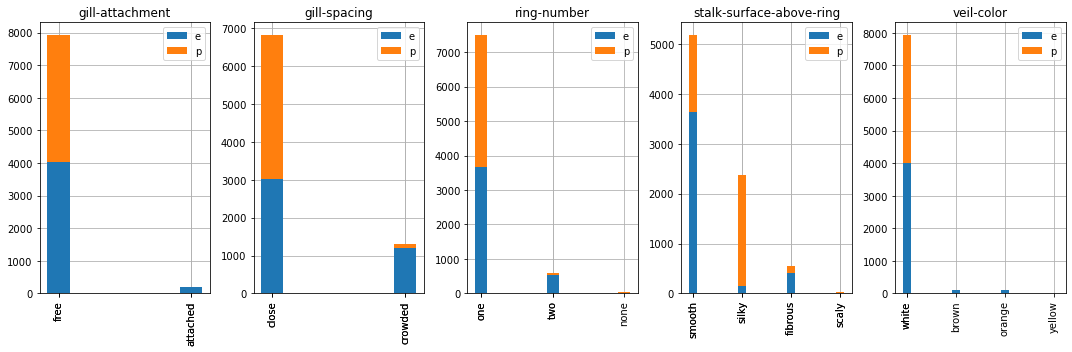

In [17]:
show_barcharts(
df_by_class_cnt[df_by_class_cnt['features'].isin(df_summary.sort_values('imbalance').tail(5).features)],
        mapping = abbr_mapping

)

most imbalanced features are veil-color, gill-attachement, ring-number, stalk-surface-above-ring and gill-spacing

### most balanced features

In [18]:
df_summary.sort_values('cnt_variation').head(6)

,features,max_type,max_count,min_type,min_count,unique_types,cnt_variation,imbalance
22,veil-type,p,8124,p,8124,1,0.000000,0
4,class,e,4208,p,3916,2,146.000000,292
18,stalk-shape,t,4608,e,3516,2,546.000000,1092
6,gill-color,b,1728,r,24,12,561.719681,1704
0,bruises,f,4748,t,3376,2,686.000000,1372
1,cap-color,n,2284,r,16,10,808.363186,2268


In [19]:
df_summary.sort_values('imbalance').head(6)

,features,max_type,max_count,min_type,min_count,unique_types,cnt_variation,imbalance
22,veil-type,p,8124,p,8124,1,0.000000,0
4,class,e,4208,p,3916,2,146.000000,292
18,stalk-shape,t,4608,e,3516,2,546.000000,1092
0,bruises,f,4748,t,3376,2,686.000000,1372
6,gill-color,b,1728,r,24,12,561.719681,1704
1,cap-color,n,2284,r,16,10,808.363186,2268


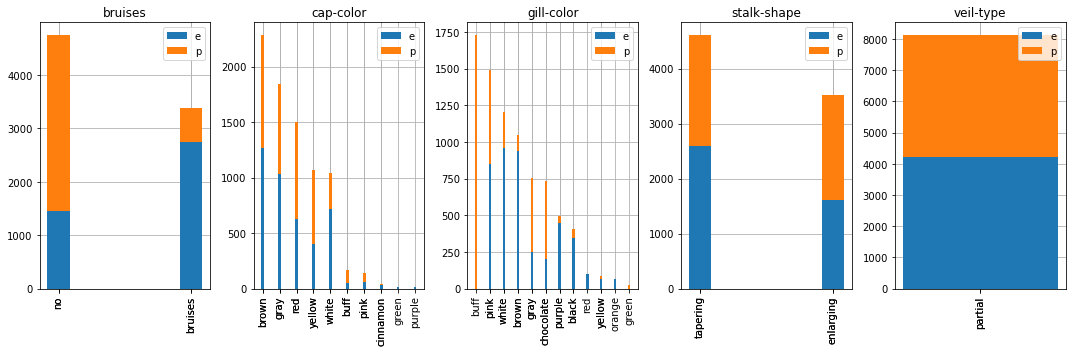

In [20]:
show_barcharts(
df_by_class_cnt[df_by_class_cnt['features'].isin(df_summary.sort_values('imbalance').head(6).features)],
            mapping = abbr_mapping

)

In [21]:
# remove class and veil_type becuase it has no variation in data
df_proccessed_features = df_raw[[col for col in df_raw.columns if col not in ['class', 'veil_type']]]
y = df_raw['class'].str.replace('e', '0').str.replace('p', '1').astype(int)

### summary
I inspected the mushroom dataset and the frequencies of each feature and its level
- there are 8124 records of 22 features
- only null values found in stalk-root, but I guess that null value is of some meanings and thus reserve this feature and place missing values as nan
- The median levels in a features is 4 level
- The features with the most levels are cap-color, gill-color, stalk-color-above-ring, spore-print-color and odor, with 9 to 12 colors or odor
- The median imbalance in a feature (max - min) is 3584, which means 44% of data volumn difference between major subclass and minor subclass on average
- The median standard diviation of frequencies in a feature is 1327.3 which is 16.3% of the data volumn
- For veil_type, there are only one subclass, that was identical to say they are all mushrooms. Therefore, we remove this feature


Overall, the subclass counts in each feature are quite imbalanced that means in most features, most records are in major subclass while only a few are in various minor class. We will expect **a lot of outliers** to train any type of models

# Encodings

In [22]:
df_one_hot = pd.get_dummies(df_proccessed_features, columns=df_proccessed_features.columns)
df_one_hot.shape

(8124, 117)

In [23]:
# to remove highly correlated features
corr_matrix = df_one_hot.corr().abs()

# create upper triangle mask
upper_triangle = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
corr_matrix[~upper_triangle] = -1.0

# get features to drop
to_drop = [column for column in corr_matrix.columns if any(corr_matrix[column][corr_matrix[column] >= 0.99])]

# drop features from DataFrame
df_one_hot = df_one_hot.drop(to_drop, axis=1)

df_one_hot.shape

(8124, 106)

In [24]:
X = df_one_hot.to_numpy()
features_encoded = df_one_hot.columns

In [25]:
print('We removed these features because they can be represented by other features:', ', '.join(to_drop))

We removed these features because they can be represented by other features: bruises_t, gill-attachment_f, gill-spacing_w, gill-size_n, stalk-shape_t, stalk-color-above-ring_c, stalk-color-below-ring_c, stalk-color-below-ring_o, veil-color_y, ring-number_n, ring-type_n


# PCA Dimenaional reduction

In [26]:
# create PCA object with 50 components
pca = PCA(n_components=50)
pca.fit(X)

# transform matrix to reduced dimensions
X_reduced = pca.transform(X)
print(X_reduced)

[[-1.24466522e+00 -7.92492941e-01  7.97531855e-01 ... -1.97627092e-01
   8.38636787e-02 -3.31329246e-02]
 [-1.35929462e+00 -1.98267808e-01  1.08708620e+00 ... -2.87146364e-03
  -3.53662843e-01 -1.65724989e-03]
 [-1.48414264e+00 -4.22564721e-01  8.06234950e-01 ... -1.58564600e-01
   3.31859501e-02 -5.11364096e-02]
 ...
 [-4.63876512e-01 -5.35473044e-01 -1.03422081e-01 ...  6.59818090e-02
   7.89240405e-02  2.79267266e-02]
 [ 1.44013885e+00 -1.82696093e+00 -1.38067720e-01 ... -8.72153688e-03
  -7.01054024e-02  7.70027752e-02]
 [-4.29059155e-01 -5.43636109e-01 -1.13419110e-02 ...  2.54927477e-01
   7.19270576e-02  1.49511361e-01]]


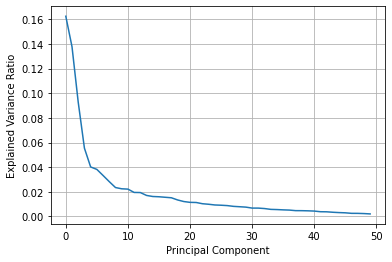

In [27]:
plt.plot(range(pca.n_components_), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid()
plt.show()

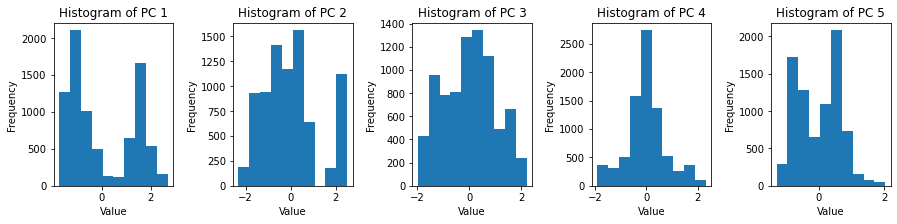

In [28]:
hist_plots(X_reduced, 5, titles = [f'Histogram of PC {i+1}' for i in range(5)])

In [29]:
for j in range(3):
    first_component = pca.components_[j]
    top5_idx = np.abs(first_component).argsort()[::-1][:5]
    top5_weights = first_component[top5_idx]
    # Print the top 5 features and their weights
    print(f'The top 5 featues of PC{j+1} with (weights) are:',
          ','.join([f"{features_encoded[feature_idx]} ({top5_weights[i]:.3f})" \
                    for i,feature_idx in enumerate(top5_idx)]), '\n')

The top 5 featues of PC1 with (weights) are: ring-type_p (-0.309),bruises_f (0.278),stalk-surface-above-ring_k (0.264),stalk-surface-below-ring_k (0.259),stalk-surface-above-ring_s (-0.241) 

The top 5 featues of PC2 with (weights) are: stalk-root_b (0.322),ring-type_e (-0.280),stalk-root_nan (-0.256),spore-print-color_h (0.254),spore-print-color_w (-0.247) 

The top 5 featues of PC3 with (weights) are: habitat_d (-0.343),habitat_g (0.325),stalk-color-above-ring_w (0.228),stalk-color-below-ring_w (0.227),population_v (-0.223) 



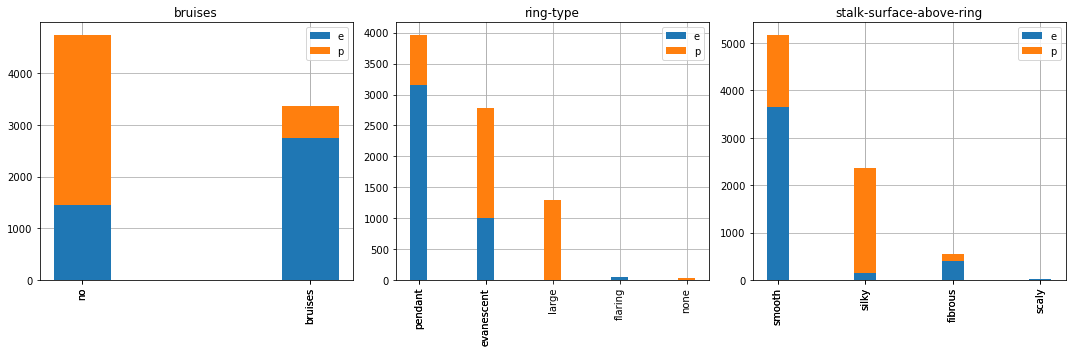

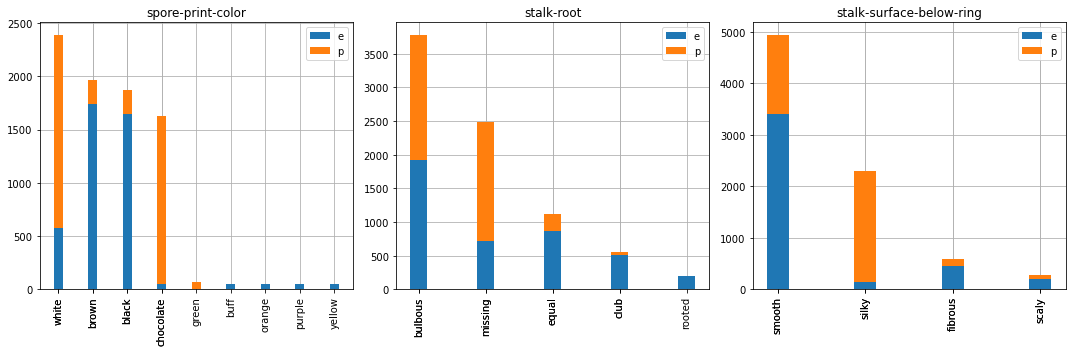

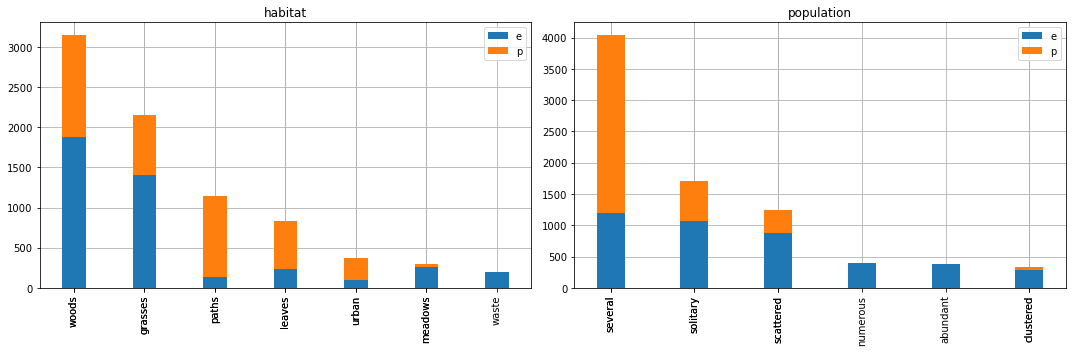

In [30]:
show_barcharts(
df_by_class_cnt[df_by_class_cnt['features'].isin(['ring-type','bruises','stalk-surface-above-ring'])],
            mapping = abbr_mapping)
show_barcharts(
df_by_class_cnt[df_by_class_cnt['features'].isin(['stalk-root','spore-print-color','stalk-surface-below-ring'])],
            mapping = abbr_mapping)
show_barcharts(
df_by_class_cnt[df_by_class_cnt['features'].isin(['habitat','population'])],
            mapping = abbr_mapping)


In [31]:
pca22 = PCA(n_components=22)
pca22.fit(X)
X_PCA22 = pca22.transform(X)

pca9 = PCA(n_components=9)
pca9.fit(X)
X_PCA9 = pca9.transform(X)

### summary
By the elbow method, the explained variance ratio changed its slope rapidly at 9th Principal Component.
We include 3 matrix
* the original encoded matrix X of shape (8124, 106)
* the PCA reduced to its original feature size X_PCA22 (8124, 22)
* the PCA reduced with elbow methode X_PCA9 (8124, 9)
* the first major principle Axis explained about 16% of the variance and are composed of ring-type, bruises, stalk-surface-above/below-ring
* the second major principle Axis explained about 14% of the variance and are composed of additionly stalk-root, spore-print-color
* the third major principe axis explained about 9% of the variance and are composed of additionaly habitat and population
* judged by histograms, PC1, PC2 and PC5 are bimodel distributed and PC3,PC4 are normal distributed

# Multi-Dimensional Scaling (MDS) dimension reduction
We employed Jaccard Distance to performing MDS.
Since Jaccard Distance is essentially intersection over union over two vectork, the endoed matrix with 1/0 are suitable for such distance calculations

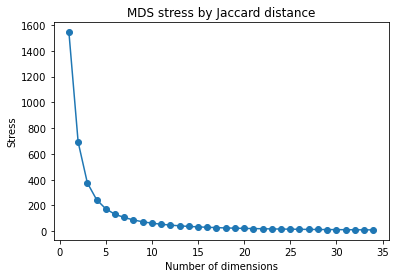

In [33]:
D_condensed = pdist(X.T, metric='jaccard')
D = squareform(D_condensed)

n_dims_range = range(1, int(min(X.shape) /3))

# Compute the stress values for each value of n_dims using MDS
stress_vals = []
for n_dims in n_dims_range:
    mds = MDS(n_components=n_dims, dissimilarity='precomputed')
    mds.fit(D)
    stress_vals.append(mds.stress_)

# Plot the stress values as a function of the number of dimensions
plt.plot(n_dims_range, stress_vals, '-o')
plt.xlabel('Number of dimensions')
plt.ylabel('Stress')
plt.title('MDS stress by Jaccard distance')
plt.show()

As shows on the plot, the stress flatened at iteration 9

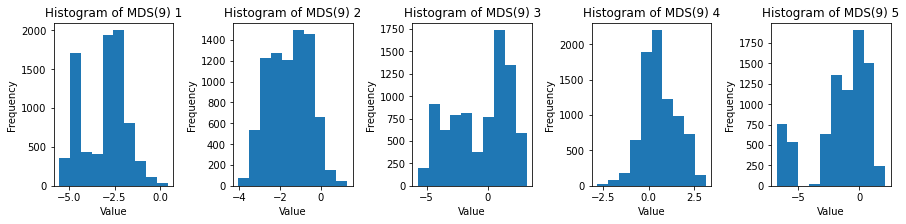

In [56]:
mds9 = MDS(n_components=9,random_state =1, dissimilarity='precomputed')
X_MDS9 = mds9.fit_transform(D)
X_MDS9 = np.dot(X,X_MDS9)
hist_plots(X_MDS9, 5, titles = [f'Histogram of MDS(9) {i+1}' for i in range(5)])

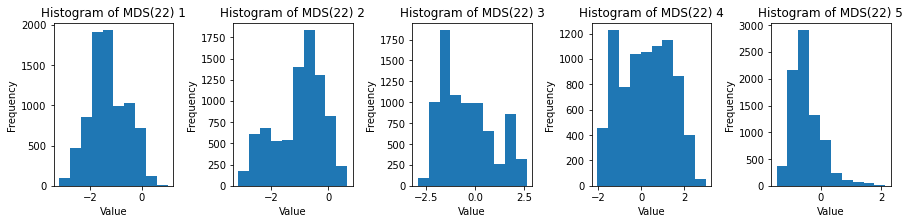

In [57]:
mds22 = MDS(n_components=22,random_state =1, dissimilarity='precomputed')
X_MDS22 = mds22.fit_transform(D)
X_MDS22 = np.dot(X,X_MDS22)

hist_plots(X_MDS22, 5, titles = [f'Histogram of MDS(22) {i+1}' for i in range(5)])

### summary
* we chose the Jaccard distance to perform Multi-dimensinal scaling
* since the dataset is large, we scale down the features based on the distance between the features and map the original data back to the reduced dimensions
* the stress became steady when n_components go to 9 like PCA
* We then compute 2 reduced datasets as PCA with X_MDS22 with n_components 22 and X_MDS9 with n_components 9

# Clustering
There are in total 5 reduced datasets to to clustered and we are clustering with Kmeans and DBSCAN

In [58]:
datasets_X = [X, X_PCA9, X_PCA22, X_MDS9, X_MDS22]
n_datasets = len(datasets_X)
datasets_title = ['original', 'PCA_9', 'PCA_22', 'MDS_9', 'MDS_22']

In [62]:
X.shape

(8124, 106)

# KMeans clustering

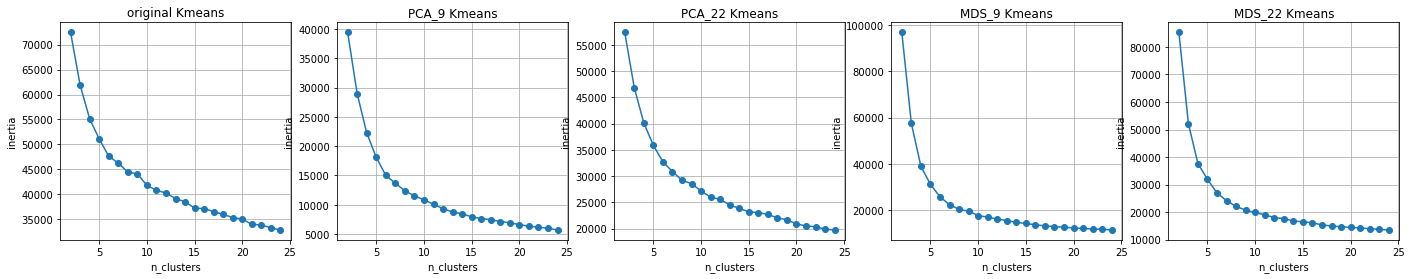

In [60]:
n_clusters_range = range(2,25)
fig, axs = plt.subplots(1,n_datasets, figsize = (24,4))
for i,X_i in enumerate(datasets_X):
    inertia = []
    for n_clusters in n_clusters_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X_i)
        inertia.append(kmeans.inertia_)
    ax = axs[i]
    ax.plot(n_clusters_range,inertia, '-o')
    ax.set_title(f"{datasets_title[i]} Kmeans")
    ax.set_xlabel('n_clusters')
    ax.set_ylabel('inertia')
    ax.grid()
plt.show()


As expected, clustering higher dimension tends to have higher inertia in Kmeans. Each dataset have different metric. We employ elbow method roughly when intertia slows down. 

We will visualize it on PCA axis and compare it to poissous/ edible labels

In [134]:
km_bestn = [15,15,15,15,15]

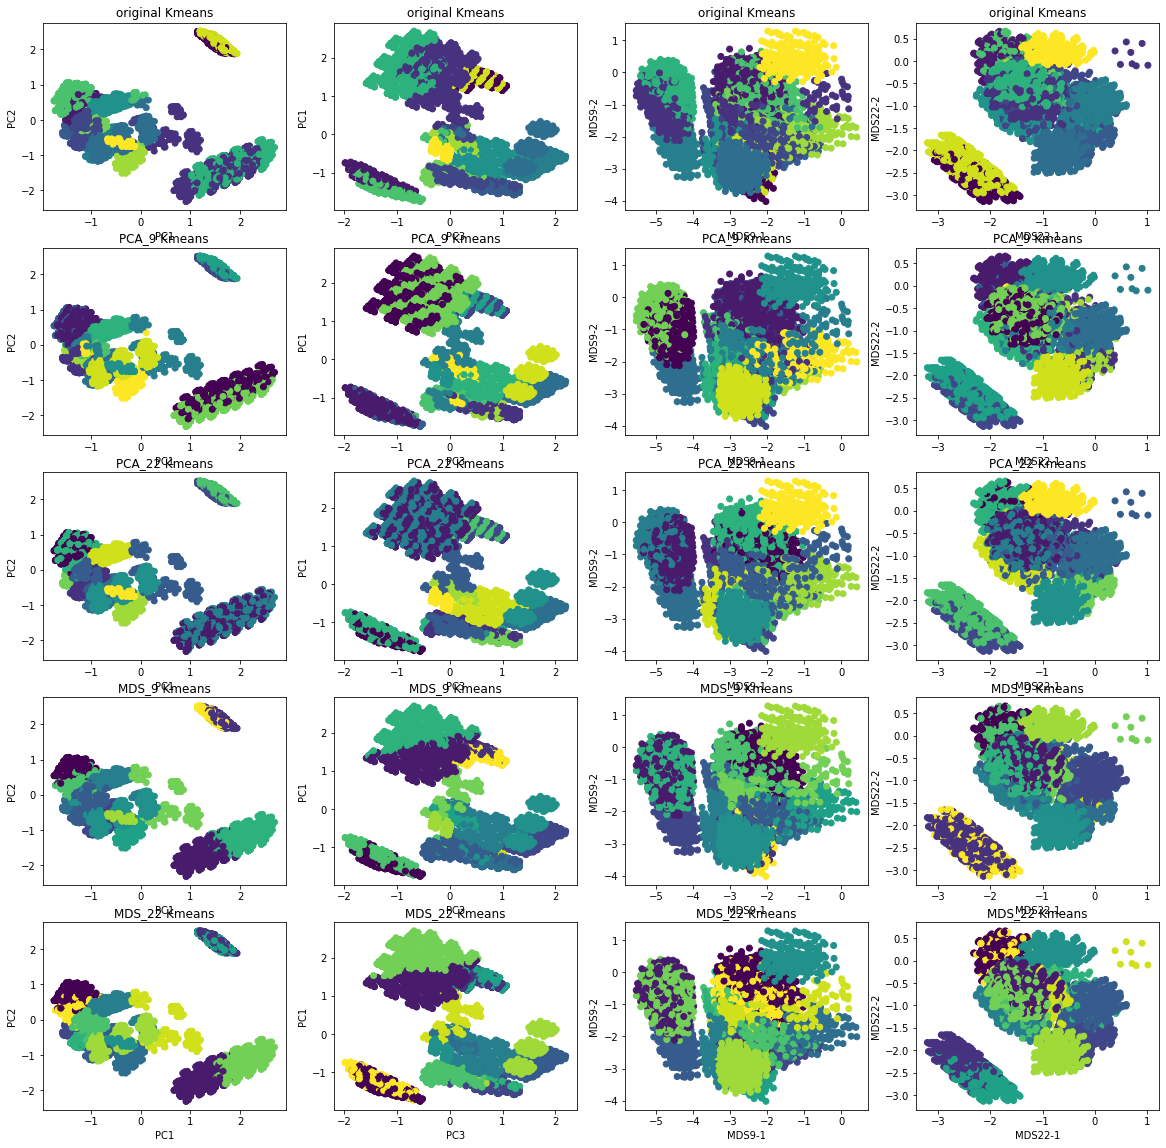

In [137]:
fig, axs = plt.subplots(n_datasets,4, figsize = (20,20))
labels_ls = []

for i,X_i in enumerate(datasets_X):
    
    kmeans = KMeans(n_clusters=km_bestn[i], random_state=0).fit(X_i)
    labels = kmeans.labels_
    labels_ls.append(labels)
    
    plot_scatter_ax(axs[i,0],0,1, X_PCA9, labels, 'PC1', 'PC2', title = f"{datasets_title[i]} Kmeans")
    plot_scatter_ax(axs[i,1],2,0, X_PCA9, labels, 'PC3', 'PC1', title = f"{datasets_title[i]} Kmeans")
    plot_scatter_ax(axs[i,2],0,1, X_MDS9, labels, 'MDS9-1', 'MDS9-2', title = f"{datasets_title[i]} Kmeans")
    plot_scatter_ax(axs[i,3],0,1, X_MDS22, labels, 'MDS22-1', 'MDS22-2', title = f"{datasets_title[i]} Kmeans")
plt.show()

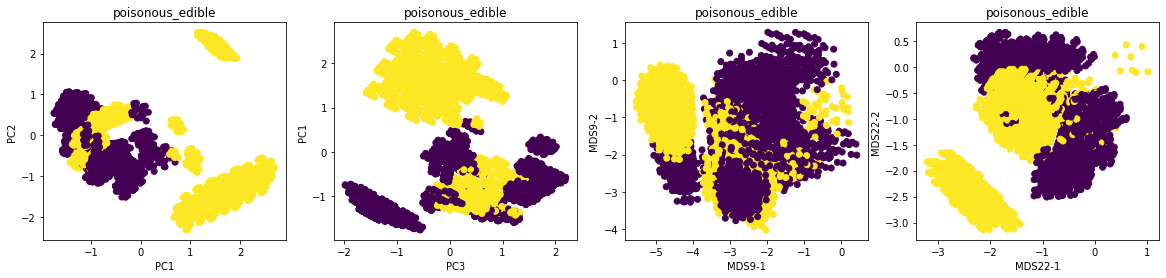

In [138]:
# compare to poisonous or edible label
fig, axs = plt.subplots(1,4, figsize = (20,4))
title = 'poisonous_edible'
plot_scatter_ax(axs[0],0,1, X_PCA9, y, 'PC1', 'PC2', title = title)
plot_scatter_ax(axs[1],2,0, X_PCA9, y, 'PC3', 'PC1', title = title)
plot_scatter_ax(axs[2],0,1, X_MDS9, y, 'MDS9-1', 'MDS9-2', title = title)
plot_scatter_ax(axs[3],0,1, X_MDS22, y, 'MDS22-1', 'MDS22-2', title = title)
plt.show()

In [139]:
df_KMeans_clusters = pd.DataFrame(np.array(labels_ls + [y]).T, columns = datasets_title + ['classes'])
df_KMeans_clusters.head()

,original,PCA_9,PCA_22,MDS_9,MDS_22,classes
0,3,2,2,4,9,1
1,4,2,11,5,3,0
2,4,2,11,5,3,0
3,3,12,2,4,9,1
4,6,5,5,3,4,0


In [140]:
df_lab_acc_ls = []
for datasets in datasets_title:
    df_lab_acc_ls.append( df_KMeans_clusters.groupby(datasets)['classes'].agg(['mean'])\
                    .reset_index()\
                    .rename(columns = {datasets:'labels', 'mean':datasets})\
                    .set_index('labels'))

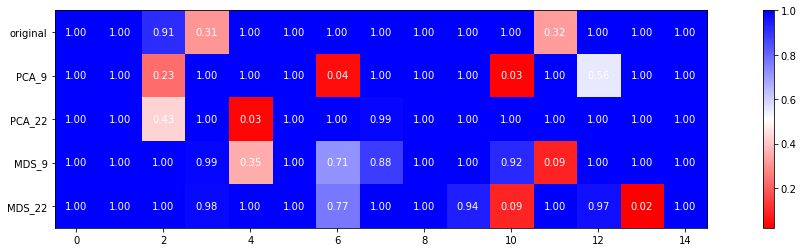

In [145]:
df_acc = abs(pd.concat(df_lab_acc_ls, axis=1) - 0.5)*2

matrix = df_acc.to_numpy().T
# Create a colorplot of the matrix
fig, ax = plt.subplots(figsize = (20,4))
im = ax.imshow(matrix, cmap='bwr_r')

# Add the matrix values as text
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        text = ax.text(j, i, '{:.2f}'.format(matrix[i, j]),
                       ha='center', va='center', color='w')
ax.set_yticks(np.arange(matrix.shape[0]))
ax.set_yticklabels(datasets_title, ha='right')
cbar = ax.figure.colorbar(im, ax=ax)

# Show the plot
plt.show()

In [143]:
df_acc.mean()

original    0.902633
PCA_9       0.790468
PCA_22      0.896434
MDS_9       0.862745
MDS_22      0.850880
dtype: float64

It turns out that the original encoded data outperforms the dimensional reduced data under Kmeans 15 clusters, with 90% times that each cluster belong to single class (poisonous/edible)

## Summary
We cluster one-hot-encoded, PCA reduced and MDS reduced data with Kmeans.
* The inertia drop rate to n_clusters of each dataset are not the same and thus we choose 15 where inertia falls flat for all.
* Based on the scatter plot with colored clustering, they all clustered differently
* Compared to class of poisonous or edible, the Kmeans clustering of original one-encoded dataset outperforms the reduced dimenson datasets
* For Kmeans original dataset, with 90.3% time that each cluster belong to a single class
* The second will be the Kmean PCA 22 dimension 89.6% time that a cluster belong to a single class , and the last is PCA 9 dimension with only 79% 
* Kmeans on MDS reduced data is of around 85% time accurate

# DBSCAN clustering

In [149]:
# generate range of eps and min_samples values
eps_range = [0.1, 0.5, 0.9 ,  1.3 , 1.7, 2.1]
min_samples_range = [2, 4, 6, 10, 12, 16]

clusters_matrix_ls = []
noise_matrix_ls = []
for feature_Matrix in [X, X_PCA9, X_PCA22, X_MDS9, X_MDS22]:
    # calculate number of clusters for each combination of eps and min_samples
    num_clusters = []
    num_noise = []
    for i,eps in enumerate(eps_range):
        for j,min_samples in enumerate(min_samples_range):
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            dbscan.fit(feature_Matrix)
            labels = dbscan.labels_
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = len([lab for lab in labels if lab ==-1])
            num_clusters.append(n_clusters)
            num_noise.append(n_noise)
            #print(eps,min_samples,n_clusters)

    clusters_matrix_ls.append(np.array(num_clusters).reshape((len(eps_range),len(min_samples_range))))
    noise_matrix_ls.append(np.array(num_noise).reshape((len(eps_range),len(min_samples_range))))

In [155]:
def matrix_cplots(xx,yy,zz_ls,title_ls = [], x_lab = '', y_lab = ''):
    fig, axs = plt.subplots(1, len(zz_ls), figsize=(4*len(zz_ls), 3))
    for cnt in range(len(zz_ls)):
        ax = axs[cnt]
        zz = zz_ls[cnt]
        ax.pcolor(xx,yy,np.log(zz))
        for i,eps in enumerate(xx[0]):
            for j,min_samples in enumerate(yy[:,0]):
                x0 = xx[i,j]
                y0 = yy[i,j]
                ax.annotate(str(round(zz[i,j],2)), 
                             xy=(x0,y0), ha='center', 
                             va='center',color='white')
        ax.set_title(title_ls[cnt])
        ax.set_xlabel(x_lab)
        ax.set_ylabel(y_lab)
    plt.show()

number of clusters


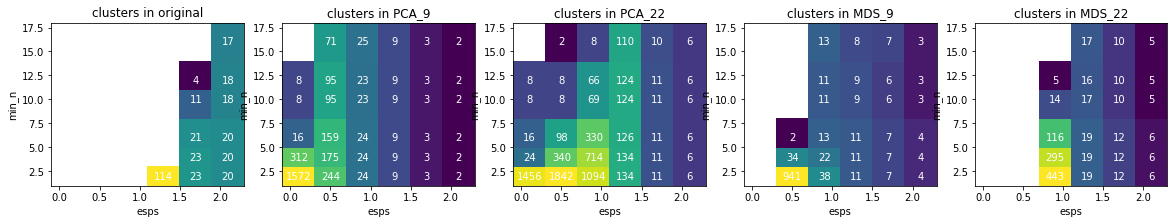

number of noise


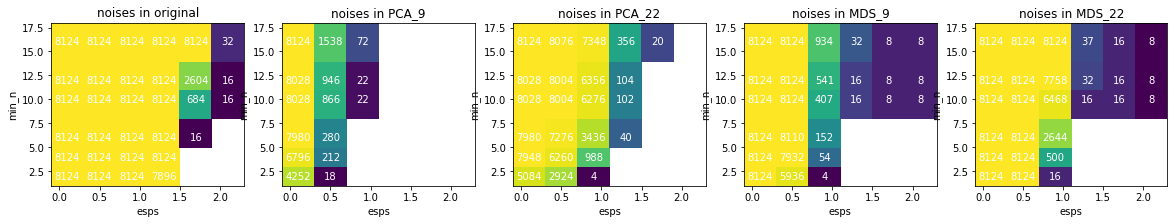

In [156]:
yy,xx = np.meshgrid(min_samples_range,eps_range)
print('number of clusters')
matrix_cplots(xx,yy,clusters_matrix_ls, title_ls = [f'clusters in {title}' for title in datasets_title],
             x_lab = 'esps', y_lab = 'min_n')
print('number of noise')
matrix_cplots(xx,yy,noise_matrix_ls, title_ls = [f'noises in {title}' for title in datasets_title],
                                                 x_lab = 'esps', y_lab = 'min_n')

Since there are 2 hyperparameter in DBSCAN and n_clusters are not fixed, we take our best guess for each dataset based on a fair number of clusters and least number of noises because we cannot see any in the plots earlier

In [160]:
db_best_esp = [2.1,0.9,1.7,1.3,1.3]
db_best_min = [6,6,6,6,6]
db_n  = [20,24,11,11,19]

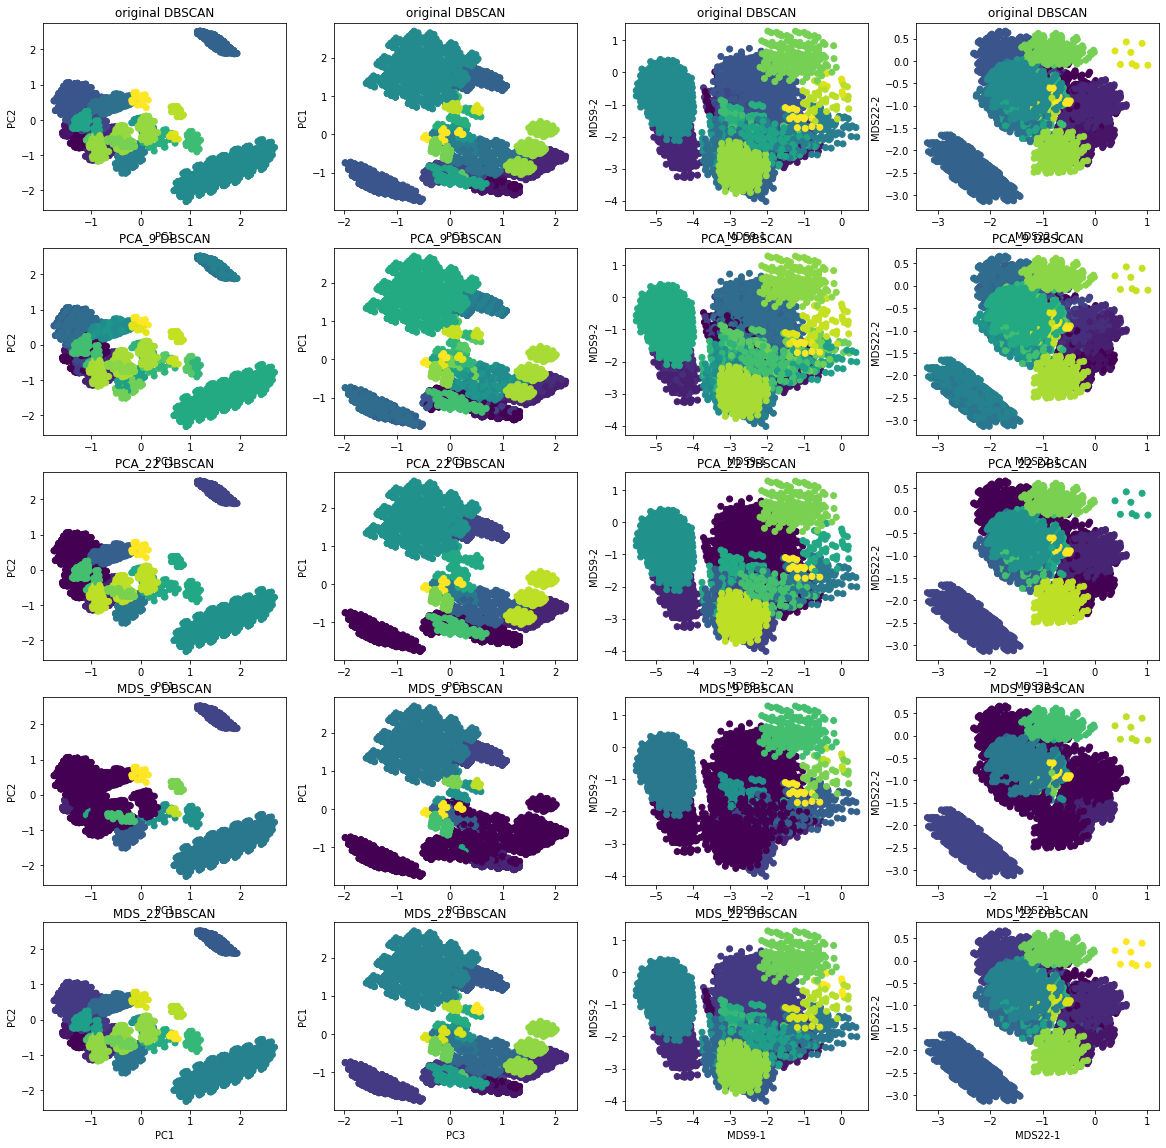

In [172]:
labels_ls = []
fig, axs = plt.subplots(n_datasets,4, figsize = (20,20))

for i,feature_Matrix in enumerate([X, X_PCA9, X_PCA22, X_MDS9, X_MDS22]):
    # calculate number of clusters for each combination of eps and min_samples
    dbscan = DBSCAN(eps=db_best_esp[i], min_samples=db_best_min[i])
    dbscan.fit(feature_Matrix)
    labels = dbscan.labels_
    labels_ls.append(labels)
    
    plot_scatter_ax(axs[i,0],0,1, X_PCA9, labels, 'PC1', 'PC2', title = f"{datasets_title[i]} DBSCAN")
    plot_scatter_ax(axs[i,1],2,0, X_PCA9, labels, 'PC3', 'PC1', title = f"{datasets_title[i]} DBSCAN")
    plot_scatter_ax(axs[i,2],0,1, X_MDS9, labels, 'MDS9-1', 'MDS9-2', title = f"{datasets_title[i]} DBSCAN")
    plot_scatter_ax(axs[i,3],0,1, X_MDS22, labels, 'MDS22-1', 'MDS22-2', title = f"{datasets_title[i]} DBSCAN")
plt.show()

In [173]:
df_DBSCANs_clusters = pd.DataFrame(np.array(labels_ls + [y]).T, columns = datasets_title + ['classes'])
df_DBSCANs_clusters.head()

,original,PCA_9,PCA_22,MDS_9,MDS_22,classes
0,0,0,0,0,0,1
1,1,0,0,1,1,0
2,1,0,0,1,1,0
3,0,1,0,0,0,1
4,2,2,1,0,2,0


In [174]:
df_lab_acc_ls = []
for datasets in datasets_title:
    df_lab_acc_ls.append( df_DBSCANs_clusters.groupby(datasets)['classes'].agg(['mean'])\
                    .reset_index()\
                    .rename(columns = {datasets:'labels', 'mean':datasets})\
                    .set_index('labels'))

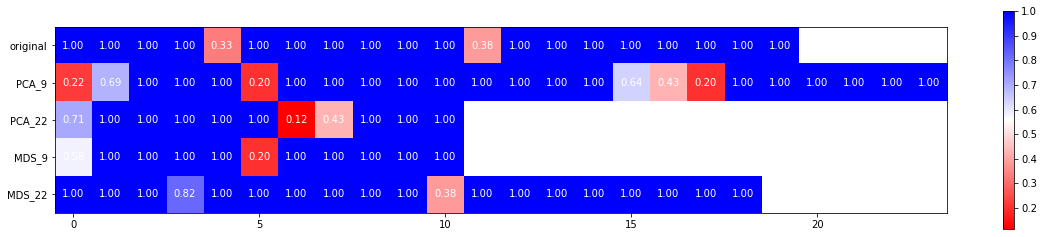

In [176]:
df_acc = abs(pd.concat(df_lab_acc_ls, axis=1) - 0.5)*2

matrix = df_acc.to_numpy().T
# Create a colorplot of the matrix
fig, ax = plt.subplots(figsize = (20,4))
im = ax.imshow(matrix, cmap='bwr_r')

# Add the matrix values as text
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        text = ax.text(j, i, '{:.2f}'.format(matrix[i, j]),
                       ha='center', va='center', color='w')
ax.set_yticks(np.arange(matrix.shape[0]))
ax.set_yticklabels(datasets_title, ha='right')
cbar = ax.figure.colorbar(im, ax=ax)

# Show the plot
plt.show()

In [178]:
df_acc.mean()

original    0.935897
PCA_9       0.849031
PCA_22      0.841199
MDS_9       0.889253
MDS_22      0.958042
dtype: float64

It is not a fair accuracy calculation because the number of classes are different. But in our DBSCAN model, The best model is based on MDS reduced 22 dataset with 95% of time a cluster belongs to the same class.

## Summary
We cluster one-hot-encoded, PCA reduced and MDS reduced data with DBSCAN.

* The optimal value for eps and min_samples hyperparameters were determined by visual inspection of the n_clusters and number of noises together.
* Based on the scatter plot with colored clustering, they all clustered differently.
* It is not a fair accuracy calculation because the number of classes are different. But in our DBSCAN model, The best model is based on MDS reduced 22 dataset with 95% of time a cluster belongs to the same class.
* For the original dataset, DBSCAN correctly identifies the class of each data point 93.6% of the time.
* The rest of models performs roughly 85% accurate.

# Discussion
## The Curse of High Dimensionality: Is it a Myth? A Comparison of KMeans and DBSCAN on Mushroom Data

The curse of high dimensionality refers to the problems that arise when working with high-dimensional data, such as increased computational complexity, sparsity, and difficulty in visualizing and interpreting results. In this project, we explore the effects of dimensionality reduction on unsupervised clustering of mushroom data using Kmeans and DBSCAN.

We started by exploring the mushroom dataset and found that it is imbalanced and contains many features with a large number of levels. We also performed PCA and MDS to reduce the dimensionality of the data. The elbow method was used to determine the optimal number of components to include in the reduced datasets.

Next, we applied Kmeans clustering to the original, PCA-reduced, and MDS-reduced datasets. We found that the original dataset outperformed the reduced dimensionality datasets in terms of clustering accuracy. However, we also observed that the different datasets clustered differently from each other.

We then applied DBSCAN to the same datasets and found that the MDS-reduced dataset with 22 components performed the best, with 95% of clusters belonging to the same class. The original dataset also performed well with a 93.6% accuracy rate, while the other reduced datasets performed roughly 85% accurately.

Overall, this project highlights the importance of considering dimensionality reduction techniques when working with high-dimensional data. While these techniques can help to alleviate the curse of high dimensionality, it is important to carefully select the optimal method and number of components to ensure that the resulting reduced dataset retains as much useful information as possible.